# DAT-NYC-37 | Lab 11 Recap | Introduction to Logistic Regression

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, cross_validation, feature_selection

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [115]:
df = pd.read_csv('https://github.com/ga-students/DAT-NYC-37/raw/master/lessons/lesson-11/datasets/bank-marketing.csv')

print df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB
None


,age,job,marital,education,default,...,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,...,1,-1,0,unknown,no
1,33,services,married,secondary,no,...,1,339,4,failure,no
2,35,management,single,tertiary,no,...,1,330,1,failure,no
3,30,management,married,tertiary,no,...,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,...,1,-1,0,unknown,no


The dataset is related to the direct marketing campaigns (by phone) of a Portuguese banking institution.  The classification goal is to predict if the client will subscribe a term deposit (variable y).

Attribute Information:

- Input variables:
  - [Bank client data]
    - `age` (numeric)
    - `job`: type of job (categorical)
    - `marital`: marital status (categorical)
      - Note: `divorced` means divorced or widowed)
    - `education` (categorical)
    - `default`: has credit in default? (categorical)
    - `balance`: bank account balance (\$)
    - `housing`: has housing loan? (categorical)
    - `loan`: has personal loan? (categorical)
  - [Data related with the last contact of the current campaign]
    - `contact`: contact communication type (categorical) 
    - `month`: last contact month of year (categorical)
    - `day_of_week`: last contact day of the week (categorical)
    - `duration`: last contact duration, in seconds (numeric)
      - Important note: this attribute highly affects the output target (e.g., if `duration = 0` then `y = 'no'`). Yet, the duration is not known before a call is performed.  Also, after the end of the call y is obviously known.  Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.    
  - [Other attributes]
    - `campaign`: number of contacts performed during this campaign and for this client (numeric)
    - `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric)
      - 999 means client was not previously contacted
    - `previous`: number of contacts performed before this campaign and for this client (numeric)
    - `poutcome`: outcome of the previous marketing campaign (categorical)

- Output variable (desired target):
  - `y`: has the client subscribed a term deposit? (binary)

## Our goal is to develop a model the best predicts the outcome `y`, the success of the marketing campaign

> ## Question 1.  Remove the categorical variables with the most number of unique values

In [153]:
# Answer:

# Step 1: Isolate categorical variables

df_categorical = df.select_dtypes(include=['object'])
print df_categorical.columns

# See which columns have the largest number of distinct columns
for col in df_categorical.columns:
    # NOTE: `df_categorical[col].nunique()` is a simpler way of expressing `len(df_categorical[col].unique())`
    
    df_column = df_categorical[col] # Select specific column
    distinct_values = df_column.unique()
    distinct_values_count = df_column.nunique()  # Same as len(distinct_values)
    
    # Type of df_column?
    # type(df_column) -> Series
    
#     print "'%s' %s unique values:  \n  %s\n" % (col, distinct_values_count, distinct_values)

# df = df.drop(['job', 'month'], axis=1)  # Option 1
# df.drop(['job', 'month'], axis=1, inplace=True) # Option 2 (May be more efficient)
# Hint: use inplace=True to modify original dataframe: df.drop(['job', 'month'], axis=1, inplace=True)

## Remove job and month columns -> Check if 'job' and 'month' column are already in my col names
if ('job', 'month') in df.columns:
    df = df.drop(['job', 'month'], axis=1)

Index([u'marital', u'education', u'default', u'housing', u'loan', u'contact',
       u'poutcome', u'y'],
      dtype='object')


> ## Question 2.  Recode all `yes`/`no` values with '1' for yes and '0' for no

In [155]:
## TIP: We can programmatically check for specific values incolumns using the following `for` loop:
# for column in df:
#     # Sets are like lists, but are (1) order independent so `set(['b', 'a']) == set(['b', 'a'])` AND (2) have all unique elements
#     if set(df[column].unique()) == set(['yes', 'no']):
#         print column

df.replace?
df['colname'].replace({'yes': 1, 'no': 0}, inplace=True)

# Note the use of `inplace=True` to allow in-place update!
# df.replace({'yes': 1, 'no': 0}, inplace=True) gives the same as: df = df.replace({'yes': 1, 'no': 0})

df.head()

,age,marital,education,default,balance,...,campaign,pdays,previous,poutcome,y
0,30,married,primary,0,1787,...,1,-1,0,unknown,0
1,33,married,secondary,0,4789,...,1,339,4,failure,0
2,35,single,tertiary,0,1350,...,1,330,1,failure,0
3,30,married,tertiary,0,1476,...,4,-1,0,unknown,0
4,59,married,secondary,0,0,...,1,-1,0,unknown,0


### <div style="color: green; text-decoration: underline;">Tip: It's generally a good idea to recode string values representing 'yes'/'no' to native True/False or 1/0 values </div>
*Why? Is more consistent when programming, it makes life easier since we can perform computation such as `mean([1, 0, 1, 1])`, etc...*

> ## Question 3.  Create binary/dummy variables for the other categorical variables

In [72]:
df.select_dtypes(include=["object"])

pd.get_dummies?

# Categorical features have a dtype of 'object'
df_categorical_features = df.select_dtypes(include=["object"])

pd.get_dummies(df_categorical_features)

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4516,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
4517,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
4518,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
4519,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0


In [66]:
df = pd.concat([pd.get_dummies(df_categorical_features), df], axis=1)

In [67]:
df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,campaign,pdays,previous,poutcome,y
0,0.0,0.0,0.0,0.0,0.0,...,1,-1,0,unknown,0
1,0.0,0.0,0.0,0.0,0.0,...,1,339,4,failure,0
2,0.0,0.0,0.0,0.0,1.0,...,1,330,1,failure,0
3,0.0,0.0,0.0,0.0,1.0,...,4,-1,0,unknown,0
4,0.0,1.0,0.0,0.0,0.0,...,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
4516,0.0,0.0,0.0,0.0,0.0,...,5,-1,0,unknown,0
4517,0.0,0.0,0.0,0.0,0.0,...,1,-1,0,unknown,0
4518,0.0,0.0,0.0,0.0,0.0,...,11,-1,0,unknown,0
4519,0.0,1.0,0.0,0.0,0.0,...,4,211,3,other,0


In [68]:
df.drop(['marital', 'education', 'contact'], axis = 1, inplace = True)

In [69]:
df.columns

Index([u'job_admin.', u'job_blue-collar', u'job_entrepreneur',
       u'job_housemaid', u'job_management', u'job_retired',
       u'job_self-employed', u'job_services', u'job_student',
       u'job_technician', u'job_unemployed', u'job_unknown',
       u'marital_divorced', u'marital_married', u'marital_single',
       u'education_primary', u'education_secondary', u'education_tertiary',
       u'education_unknown', u'contact_cellular', u'contact_telephone',
       u'contact_unknown', u'month_apr', u'month_aug', u'month_dec',
       u'month_feb', u'month_jan', u'month_jul', u'month_jun', u'month_mar',
       u'month_may', u'month_nov', u'month_oct', u'month_sep',
       u'poutcome_failure', u'poutcome_other', u'poutcome_success',
       u'poutcome_unknown', u'age', u'job', u'default', u'balance', u'housing',
       u'loan', u'day', u'month', u'duration', u'campaign', u'pdays',
       u'previous', u'poutcome', u'y'],
      dtype='object')

> ## Question 4.  Split the dataset into a training set (60%) and a testing set (the rest)

In [70]:
train_df = df.sample(frac = .6, random_state = 0)
test_df = df.drop(train_df.index)

> ## Question 5.  Run a logistic regression with `age`, `marital` (the dummies), `default`, `balance`, `housing`, `loan`, `campaign`, `pdays`, `previous`

In [94]:
names_X = ['age', 'marital_single', 'marital_divorced',
    'default', 'balance', 'housing',
    'loan', 'campaign', 'previous']

def X_y(df):
    X = df[ names_X ]
    y = df.y
    return X, y

train_X, train_y = X_y(train_df)
test_X, test_y = X_y(test_df)

train_X

,age,marital_single,marital_divorced,default,balance,housing,loan,campaign,previous
4274,0.246154,0.0,0.0,0.0,0.120338,1.0,0.0,0.064516,0.00
72,0.184615,1.0,0.0,0.0,0.311718,1.0,0.0,0.032258,0.00
1065,0.169231,0.0,0.0,0.0,0.108014,1.0,0.0,0.000000,0.00
3185,0.353846,0.0,0.0,0.0,0.125261,1.0,1.0,0.064516,0.00
130,0.338462,0.0,0.0,0.0,0.113491,1.0,0.0,0.064516,0.00
...,...,...,...,...,...,...,...,...,...
1817,0.123077,0.0,0.0,0.0,0.178795,1.0,0.0,0.000000,0.04
2642,0.415385,0.0,0.0,0.0,0.112676,1.0,0.0,0.000000,0.00
3302,0.215385,0.0,1.0,0.0,0.108014,1.0,1.0,0.225806,0.00
1993,0.323077,0.0,0.0,0.0,0.121674,1.0,0.0,0.000000,0.00


In [113]:
# Note: This is exactly the same process as LinearRegression, only we're using `linear_model.LogisticRegression()` instead of `linear_model.LinearRegression()`
model = linear_model.LogisticRegression()
model.fit(train_X, train_y)

print 'intercept    =', model.intercept_
print 'coefficients =', model.coef_

res = zip(model.coef_[0], names_X)
res.sort()

intercept    = [-2.1434767]
coefficients = [[ 0.73776217  0.50097848  0.45971056 -0.00834978  0.49097826 -0.6515322
  -0.70075317 -1.26593839  2.13422649]]


> ## Question 8.  What is your training error?  What is your generalization error?  Does it make sense?

In [78]:
print 'training misclassification =', model.score(train_X, train_y)
print 'testing  misclassification =', model.score(test_X, test_y)

training misclassification = 0.883155178769
testing  misclassification = 0.885508849558


Answer: The generalization error is higher than the training error.  Yes, this make sense since the model should better fit the training set.

> ## Question 9.  Interpret your coefficients. (At least `marital_single`, `campaign`, and `default`).  Does your interpretation  make sense?

In [81]:
zip(names_X, np.exp(model.coef_[0]) - 1)

[('age', 0.010411205027578196),
 ('marital_single', 0.61957089072540605),
 ('marital_divorced', 0.55463207895892541),
 ('default', 0.0063404605864321173),
 ('balance', 2.3778709578703427e-05),
 ('housing', -0.51095377254478769),
 ('loan', -0.49278581292571644),
 ('campaign', -0.059244768670652759),
 ('pdays', 0.0017031501488582457),
 ('previous', 0.079048405088249396)]

**Answer:** The odds that single individuals are targeted successfully by this campaign is 59% more than married people.  Perhaps if people are married they need to consult with their spouse but singles can decide on themselves.

Every extra time a client is contacted - the odds of usefulness of the marketing campaign decreases by 6%; maybe clients get frustrated overtime.

The odds of effectiveness of this campaign on those people who have not defaulted on their loans is 1.5% less than those who did.  This may suggest that those who are responsible borrowers are more careful with how to respond to bank offers.

> ## Question 10.  What is your prediction for a 30 years old single female, a homeowner with a \$1,000 balance in the bank, without a loan, who has never been contacted before, and who has never defaulted.

In [82]:
predict_x = [30, 1, 0, 0, 1000, 1, 0, 3, 999, 0]

print model.predict(predict_x)
print model.predict_proba(predict_x)

[0]
[[ 0.64847044  0.35152956]]


/Users/Aerlinger/.pyenv/versions/2.7.11/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Aerlinger/.pyenv/versions/2.7.11/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Answer:

> ## Question 11.  Normalize your variables.  (You can reuse the function from the previous lab)

In [83]:
def normalize(x):
    min = x.min()
    max = x.max()
    return (x - min) / (max - min)

train_df[ names_X ] = train_df[ names_X ].apply(normalize)

> ## Question 12.  Let's do some regularization.  Use 10-fold cross validation to find the best tuning parameter `c`

(Hint: check the documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

Note: `c` is just the inverse of $\lambda$ - the smaller $c$, the stronger the regularization. The smaller values choose less variables

(Hint 2: First try c = 10 ^ i with i = -10 ... 10)

In [85]:
c_df = pd.DataFrame({'index': np.linspace(-10, 10, 21)})

c_df['c'] = c_df['index'].apply(lambda index: 10 ** index)

def optimize_c(c):
    model = linear_model.LogisticRegression(C = c)
    return cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

c_df['Score'] = c_df.c.apply(optimize_c)

c_df

,index,c,Score
0,-10.0,1.000000e-10,0.815353
1,-9.0,1.000000e-09,0.815351
2,-8.0,1.000000e-08,0.821244
3,-7.0,1.000000e-07,0.848147
4,-6.0,1.000000e-06,0.883529
...,...,...,...
16,6.0,1.000000e+06,0.882789
17,7.0,1.000000e+07,0.882789
18,8.0,1.000000e+08,0.882789
19,9.0,1.000000e+09,0.882789


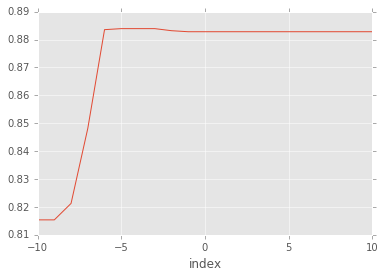

In [89]:
c_df.set_index('index').Score.plot();

Answer:

> ## Question 13.  Now use the best `c` you found above and repeat your analysis; look over your coefficients

In [86]:
model = linear_model.LogisticRegression(C = 10 ** -6.25)
model.fit(train_X, train_y)

zip(np.exp(model.coef_[0]) - 1, names_X)

[(-0.011011342929635126, 'age'),
 (-7.0557453049291396e-05, 'marital_single'),
 (-2.8663783525728626e-05, 'marital_divorced'),
 (-8.0376207040044889e-06, 'default'),
 (-0.00031404998077977364, 'balance'),
 (-0.00019634832108916811, 'housing'),
 (-6.0636827106885782e-05, 'loan'),
 (-0.00090876124256344948, 'campaign'),
 (-0.0017347968636026723, 'pdays'),
 (-1.1726748733953407e-05, 'previous')]

> ## Question 14.  If you want to drop 3 variables from your analysis, which variables will you choose?

In [87]:
# sort to looks at the values; pay attention to negative coefficients!

sorted(zip(abs(np.exp(model.coef_[0]) - 1), names_X))

[(8.0376207040044889e-06, 'default'),
 (1.1726748733953407e-05, 'previous'),
 (2.8663783525728626e-05, 'marital_divorced'),
 (6.0636827106885782e-05, 'loan'),
 (7.0557453049291396e-05, 'marital_single'),
 (0.00019634832108916811, 'housing'),
 (0.00031404998077977364, 'balance'),
 (0.00090876124256344948, 'campaign'),
 (0.0017347968636026723, 'pdays'),
 (0.011011342929635126, 'age')]

Answer: `default`, `previous`, and `marital_divorced` since they have the smallest coefficients under the optimal `c`.